# Medical Machine Learning: Projet

L'objectif principal de ce projet est de concevoir un système automatisé capable d'analyser des images de scanner 3D (CT-scan) pour y segmenter deux structures critiques : les vaisseaux sanguins hépatiques et les tumeurs. Cette tâche est essentielle pour assister les médecins dans le diagnostic et la planification chirurgicale, mais elle reste un défi technique majeur : les vaisseaux forment un réseau très fin et complexe, tandis que les tumeurs sont des masses dont la texture ressemble parfois aux tissus sains.

Pour répondre à ce défi, notre travail s'articule autour de la mise en œuvre et de la comparaison de deux approches techniques radicalement différentes :
    
- Une approche "Classique" (ITK) : Nous explorons d'abord une méthode basée sur le traitement d'image traditionnel. Elle utilise des calculs géométriques et mathématiques pour filtrer l'image en se basant uniquement sur la forme et la brillance des objets.
    
- Une approche "Intelligence Artificielle" (MONAI) : Nous développons ensuite une solution d'apprentissage profond (Deep Learning). Contrairement à la première méthode, ce système apprend par lui-même à comprendre le contexte médical pour distinguer sémantiquement les vaisseaux des tumeurs, et les différencier des autres organes comme les os.

Ce rapport détaille les étapes de construction de ces deux pipelines, depuis l'analyse statistique des données brutes jusqu'à leur implémentation respective.

In [ ]:
import os
import sys
import json
import nibabel as nib
import numpy as np
import pandas as pd
import itk
import monai
import matplotlib.pyplot as plt
from glob import glob

# Analyse statistique

--- Info Dataset ---
Nom: HepaticVessel
Modalité: {'0': 'CT'}
Labels: {'0': 'background', '1': 'Vessel', '2': 'Tumour'}
Nombre training (json): 303
Nombre test (json): 139

--- Analyse de 303 volumes (cela peut prendre du temps) ---
Traité: hepaticvessel_001.nii.gz | Shape: (512, 512, 49) | Spacing: (np.float32(0.917969), np.float32(0.917969), np.float32(5.0))
Traité: hepaticvessel_002.nii.gz | Shape: (512, 512, 66) | Spacing: (np.float32(0.951172), np.float32(0.951172), np.float32(3.75))
Traité: hepaticvessel_004.nii.gz | Shape: (512, 512, 43) | Spacing: (np.float32(0.976562), np.float32(0.976562), np.float32(5.0))
Traité: hepaticvessel_005.nii.gz | Shape: (512, 512, 41) | Spacing: (np.float32(0.976562), np.float32(0.976562), np.float32(5.0))
Traité: hepaticvessel_007.nii.gz | Shape: (512, 512, 50) | Spacing: (np.float32(0.894531), np.float32(0.894531), np.float32(5.0))
Traité: hepaticvessel_008.nii.gz | Shape: (512, 512, 47) | Spacing: (np.float32(0.84375), np.float32(0.84375), np.fl

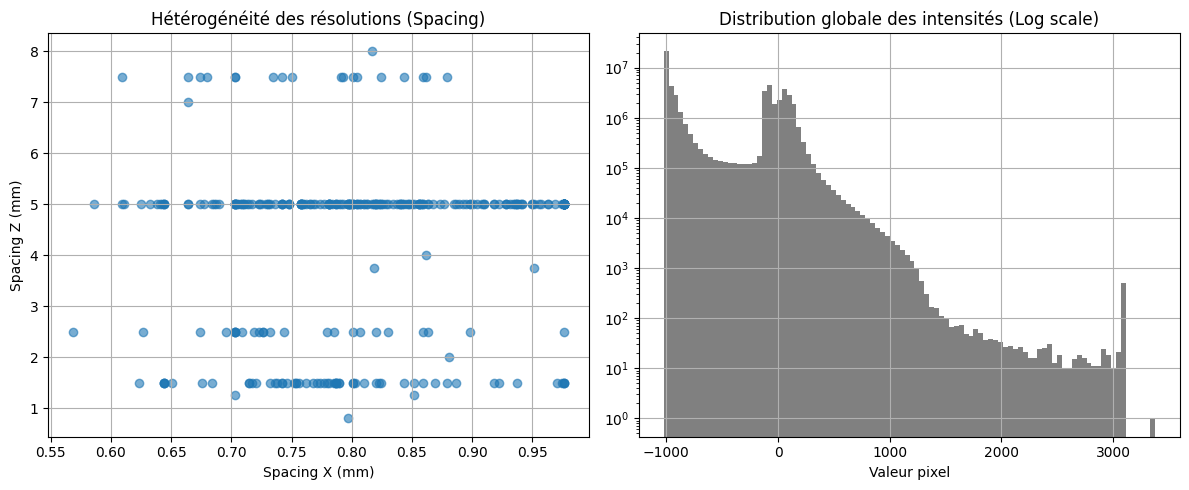


--- Résumé Statistique ---
        spacing_x   spacing_z       dim_z  min_intensity  max_intensity
count  303.000000  303.000000  303.000000          303.0     303.000000
mean     0.804887    4.240264   69.702970        -1024.0    1797.006601
std      0.097402    1.691427   43.876379            0.0     725.772865
min      0.568359    0.800003   24.000000        -1024.0     982.000000
25%      0.732422    2.500000   41.000000        -1024.0    1292.000000
50%      0.798828    5.000000   49.000000        -1024.0    1404.000000
75%      0.863281    5.000000   93.500000        -1024.0    2195.000000
max      0.976562    8.000000  181.000000        -1024.0    4543.000000

--- Distribution moyenne des classes (%) ---
pct_bg         99.531262
pct_class_1     0.109027
pct_class_2     0.359711
dtype: float64


In [ ]:
# Chemins des données
DATA_ROOT = "/home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/"
IMAGES_TR_DIR = os.path.join(DATA_ROOT, "imagesTr")
LABELS_TR_DIR = os.path.join(DATA_ROOT, "labelsTr")

def analyze_dataset():
    # Chargement du dataset.json
    json_path = os.path.join(DATA_ROOT, "dataset.json")
    with open(json_path, 'r') as f:
        data_info = json.load(f)
    
    print(f"--- Info Dataset ---")
    print(f"Nom: {data_info.get('name', 'N/A')}")
    print(f"Modalité: {data_info.get('modality', 'N/A')}")
    print(f"Labels: {data_info.get('labels', 'N/A')}")
    print(f"Nombre training (json): {len(data_info.get('training', []))}")
    print(f"Nombre test (json): {len(data_info.get('test', []))}")

    # Analyse des fichiers d'entraînement
    image_files = sorted(glob(os.path.join(IMAGES_TR_DIR, "*.nii.gz")))
    label_files = sorted(glob(os.path.join(LABELS_TR_DIR, "*.nii.gz")))
    
    assert len(image_files) == len(label_files), "Mismatch nombre images/labels"

    stats = []
    pixel_intensities = []
    
    print(f"\n--- Analyse de {len(image_files)} volumes (cela peut prendre du temps) ---")
    
    for img_path, lbl_path in zip(image_files, label_files):
        # Chargement Header Image
        img_obj = nib.load(img_path)
        header = img_obj.header
        data = img_obj.get_fdata()
        
        # Chargement Label pour stats de classe
        lbl_obj = nib.load(lbl_path)
        lbl_data = lbl_obj.get_fdata()
        
        # Métriques géométriques
        shape = header.get_data_shape()
        spacing = header.get_zooms()
        
        # Métriques d'intensité
        curr_min = np.min(data)
        curr_max = np.max(data)
        curr_mean = np.mean(data)
        
        # Échantillonnage pour l'histogramme global des intensités
        pixel_intensities.extend(data.ravel()[::100])
        
        # Équilibre des classes
        unique, counts = np.unique(lbl_data, return_counts=True)
        class_counts = dict(zip(unique.astype(int), counts))
        total_voxels = np.prod(shape)
        
        record = {
            "id": os.path.basename(img_path),
            "dim_x": shape[0], "dim_y": shape[1], "dim_z": shape[2],
            "spacing_x": spacing[0], "spacing_y": spacing[1], "spacing_z": spacing[2],
            "min_intensity": curr_min,
            "max_intensity": curr_max,
            "mean_intensity": curr_mean,
            "pct_bg": class_counts.get(0, 0) / total_voxels * 100,
            "pct_class_1": class_counts.get(1, 0) / total_voxels * 100,
            "pct_class_2": class_counts.get(2, 0) / total_voxels * 100
        }
        stats.append(record)
        print(f"Traité: {os.path.basename(img_path)} | Shape: {shape} | Spacing: {spacing}")

    df = pd.DataFrame(stats)
    
    return df, pixel_intensities


df_stats, global_intensities = analyze_dataset()

# Visualisations
# Distribution des tailles de voxels (Spacing)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_stats['spacing_x'], df_stats['spacing_z'], alpha=0.6)
plt.xlabel('Spacing X (mm)')
plt.ylabel('Spacing Z (mm)')
plt.title('Hétérogénéité des résolutions (Spacing)')
plt.grid(True)

# Distribution des intensités
plt.subplot(1, 2, 2)
plt.hist(global_intensities, bins=100, color='gray', log=True)
plt.title('Distribution globale des intensités (Log scale)')
plt.xlabel('Valeur pixel')
plt.grid(True)

plt.tight_layout()
plt.show()

# Affichage des statistiques résumées
print("\n--- Résumé Statistique ---")
print(df_stats[['spacing_x', 'spacing_z', 'dim_z', 'min_intensity', 'max_intensity']].describe())
print("\n--- Distribution moyenne des classes (%) ---")
print(df_stats[['pct_bg', 'pct_class_1', 'pct_class_2']].mean())

### Analyse des résultats

Avant de commencer à créer nos programmes, nous avons pris le temps d'analyser les images du dataset fournies pour comprendre à quoi nous avions affaire. Cette étape est cruciale car elle nous a permis de repérer trois grandes particularités qui auraient pu piéger l'ordinateur si nous ne les avions pas identifiées.

La première observation concerne la géométrie des images. Un scanner fonctionne en découpant le corps humain en "tranches" virtuelles. Nous avons remarqué que ces tranches n'ont pas toujours la même épaisseur : pour certains patients, elles sont très fines, tandis que pour d'autres, elles sont épaisses. C'est un problème majeur car cela déforme la réalité 3D : si nous ne corrigeons pas cela, l'ordinateur verra certains organes comme étant écrasés ou étirés, un peu comme dans un miroir déformant, ce qui l'empêchera d'apprendre correctement la forme des structures anatomiques.

La deuxième découverte touche aux couleurs et à la luminosité des images. Les scanners enregistrent une gamme de nuances immense, allant du noir total pour l'air au blanc pour les os et le métal. Le problème est que ce qui nous intéresse, c'est-à-dire le foie, les vaisseaux et les tumeurs, se trouve dans des nuances de gris très subtiles au milieu. Si on laisse les os très brillants dans l'image, cela écrase tout le contraste : l'ordinateur est "ébloui" par le blanc des os et n'arrive plus à distinguer les détails fins dans les zones grises qui nous intéressent. Il faudra donc trouver un moyen de masquer ces extrêmes.

Enfin, nous avons réalisé un dernier défi de taille concernant nos cibles. Le jeu de données nous demande de trouver deux choses distinctes : les vaisseaux sanguins et les tumeurs. En calculant le volume occupé par chaque élément, nous avons vu qu'ils ne représentent qu'une infime fraction de l'image : à peine 0.1% pour les vaisseaux et 0.3% pour les tumeurs. Tout le reste (plus de 99%), c'est du fond noir ou d'autres organes. Les données sont donc très déséquilibrées. C'est un piège redoutable car, sans correction, le modèle choisira la facilité : il prédira qu'il n'y a "rien" partout, ce qui lui donnera techniquement raison sur 99% de l'image, mais lui fera rater les pathologies essentielles.

### Choix techniques pour la suite

L'analyse de nos données a révélé deux obstacles majeurs : la qualité très inégale des images selon les patients et la difficulté à repérer nos cibles — les vaisseaux et les tumeurs — qui sont minuscules par rapport au reste du corps. Ces constats nous ont obligés à adapter nos méthodes de calcul.

Pour l'approche classique (ITK), le principal souci est que les os apparaissent très brillants sur les scanners, ce qui a tendance à "aveugler" l'ordinateur qui les confond avec les zones contrastées que nous cherchons. Pour régler cela, nous utilisons une technique appelée "Clamping", qui consiste à ignorer volontairement tout ce qui est trop blanc (les os) ou trop noir (l'air) pour ne se concentrer que sur les tissus mous. Ensuite, pour tenter d'isoler les vaisseaux au milieu de tout cela, nous appliquons un filtre mathématique nommé White Top-hat. Au lieu de chercher une forme globale, cet outil isole spécifiquement tout ce qui ressemble à des petits tubes brillants et efface le reste, ce qui aide à la détection.

Pour le modèle d'IA (MONAI), le défi est différent car il doit apprendre à distinguer trois choses : le fond, les vaisseaux et les tumeurs. D'abord, nous devons redimensionner mathématiquement tous les volumes pour qu'ils aient la même échelle, afin d'éviter que l'IA ne voie des organes déformés selon les patients. Le second problème est que les données sont très "unbalanced" (déséquilibrées) : il y a trop de vide pour très peu de matière médicale. Pour contrer cela, nous découpons les images en petits cubes et nous utilisons une stratégie d'échantillonnage forcée : nous obligeons l'IA à travailler sur des cubes contenant spécifiquement des vaisseaux ou des tumeurs. Enfin, nous changeons sa notation avec le "Score Dice". Cette méthode ne lui donne des points que si elle localise correctement ces deux pathologies, la punissant sévèrement si elle choisit la facilité en prédisant du vide.

# ITK

In [46]:
def itk_pipeline_segmentation(input_path, output_path):
    print(f"Traitement de : {os.path.basename(input_path)}")
    
    PixelTypeFloat = itk.F
    PixelTypeUC = itk.UC
    Dimension = 3
    
    ImageTypeFloat = itk.Image[PixelTypeFloat, Dimension]
    ImageTypeUC = itk.Image[PixelTypeUC, Dimension]

    # Chargement
    input_img = itk.imread(input_path, PixelTypeFloat)
    
    # Prétraitement 
    img_smooth = itk.discrete_gaussian_image_filter(input_img, variance=1.0)
    
    # Transformation "White Top-Hat"
    radius = 3
    StructuringElementType = itk.FlatStructuringElement[Dimension]
    structuring_element = StructuringElementType.Ball(radius)
    
    img_background = itk.grayscale_morphological_opening_image_filter(
        img_smooth,
        kernel=structuring_element
    )
    
    img_tophat = itk.subtract_image_filter(img_smooth, img_background)
    
    # Seuillage
    binary_mask = itk.binary_threshold_image_filter(
        img_tophat,
        lower_threshold=15.0,
        upper_threshold=3000.0,
        inside_value=1.0,
        outside_value=0.0
    )
    
    # Nettoyage final
    radius_clean = 1
    se_clean = StructuringElementType.Ball(radius_clean)
    
    clean_mask = itk.binary_morphological_opening_image_filter(
        binary_mask,
        kernel=se_clean,
        foreground_value=1.0
    )
    
    # Sauvegarde
    final_output = itk.cast_image_filter(
        clean_mask, 
        ttype=(ImageTypeFloat, ImageTypeUC)
    )
    
    itk.imwrite(final_output, output_path)
    print(f"Sauvegardé : {output_path}")


image_files = sorted(glob(os.path.join(IMAGES_TR_DIR, "*.nii.gz")))
k = 10
for img_path in image_files[:k]:
    base_name = os.path.basename(img_path).replace("hepaticvessel_", "prediction_itk_")
    output_path = os.path.join(DATA_ROOT, "predictions_itk", base_name)
    try:
        itk_pipeline_segmentation(img_path, output_path)
    except Exception as e:
        print(f"Erreur ITK pour {img_path} : {e}")

Traitement de : hepaticvessel_001.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/prediction_itk_001.nii.gz
Traitement de : hepaticvessel_002.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/prediction_itk_002.nii.gz
Traitement de : hepaticvessel_004.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/prediction_itk_004.nii.gz
Traitement de : hepaticvessel_005.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/prediction_itk_005.nii.gz
Traitement de : hepaticvessel_007.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/prediction_itk_007.nii.gz
Traitement de : hepaticvessel_008.nii.gz
Sauvegardé : /home/clement/2026/S9/Medical_ML/Task08_HepaticVessel/Task08_HepaticVessel/predictions_itk/

Visualisation pour hepaticvessel_001.nii.gz
Affichage de la coupe Z = 15


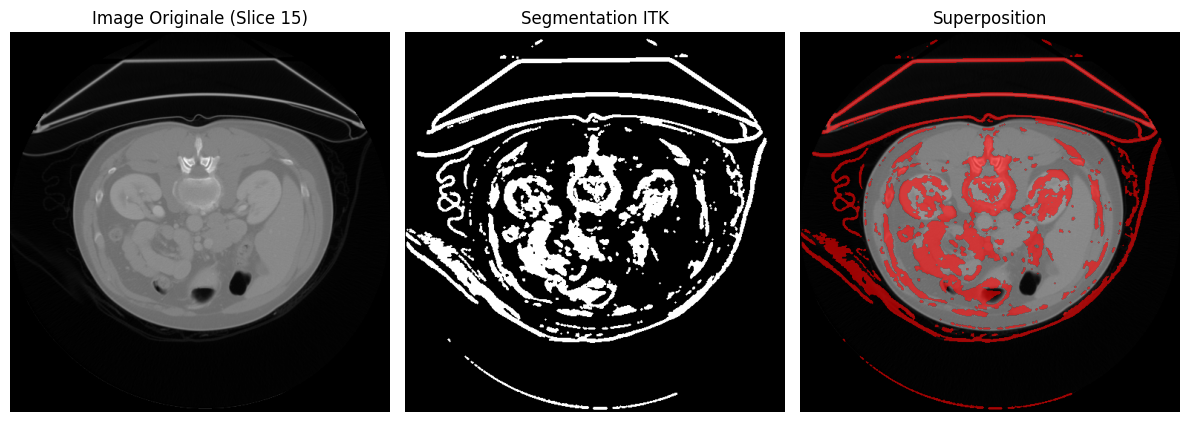



Visualisation pour hepaticvessel_002.nii.gz
Affichage de la coupe Z = 30


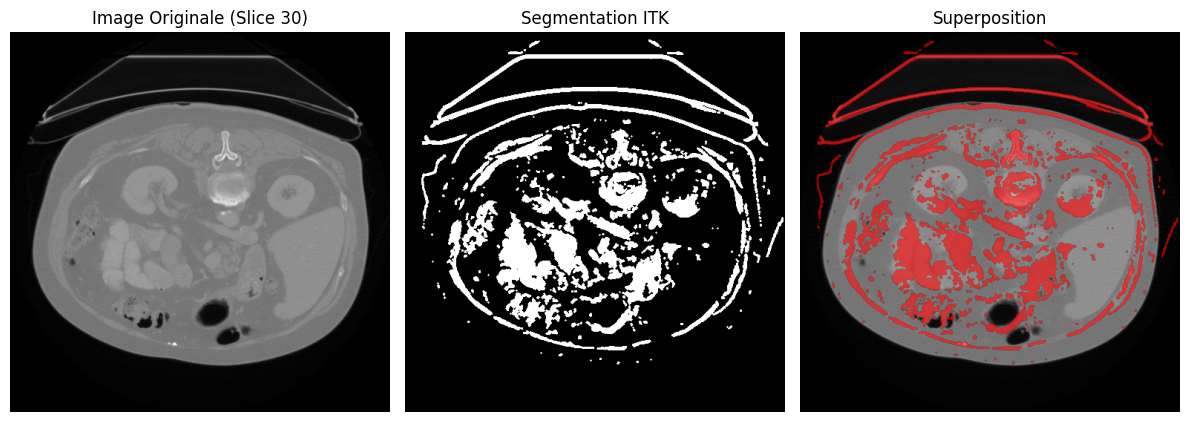



Visualisation pour hepaticvessel_004.nii.gz
Affichage de la coupe Z = 11


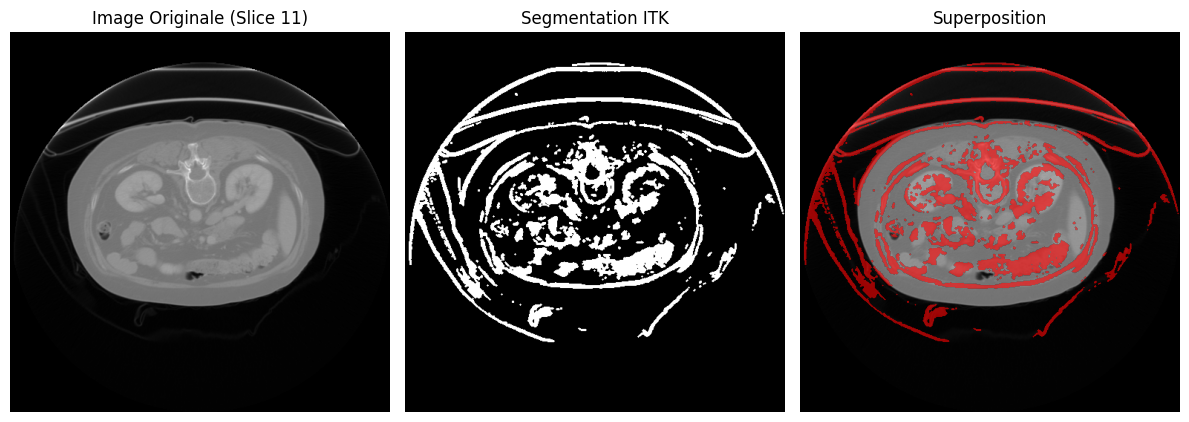



Visualisation pour hepaticvessel_005.nii.gz
Affichage de la coupe Z = 24


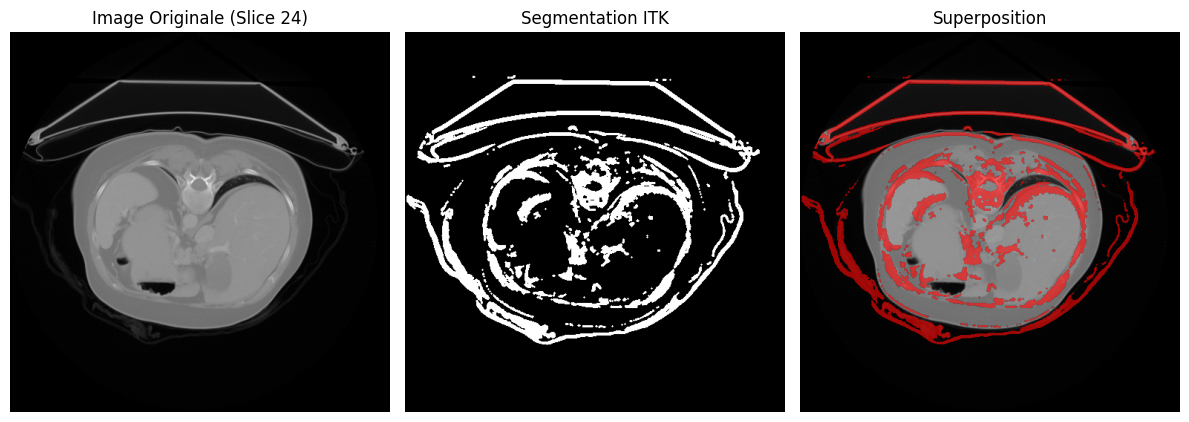



Visualisation pour hepaticvessel_007.nii.gz
Affichage de la coupe Z = 21


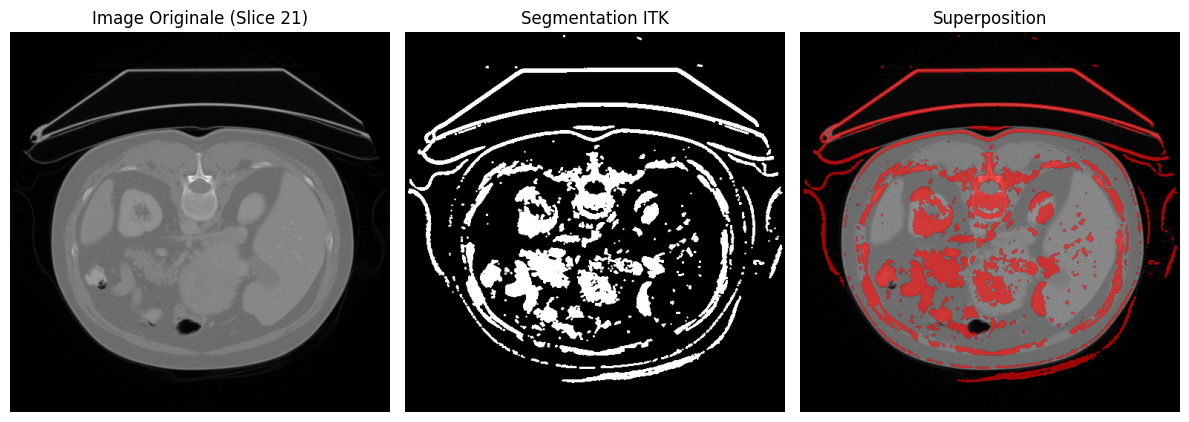



Visualisation pour hepaticvessel_008.nii.gz
Affichage de la coupe Z = 42


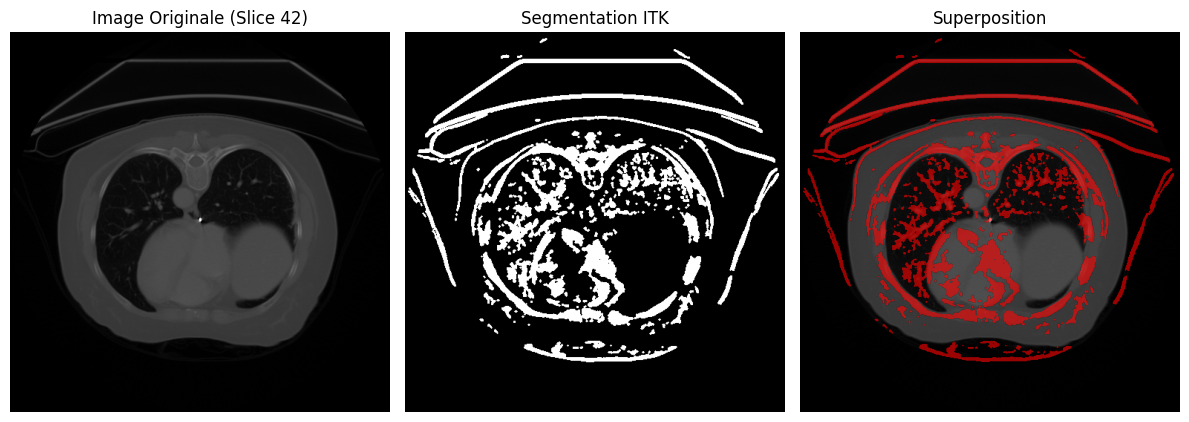



Visualisation pour hepaticvessel_010.nii.gz
Affichage de la coupe Z = 21


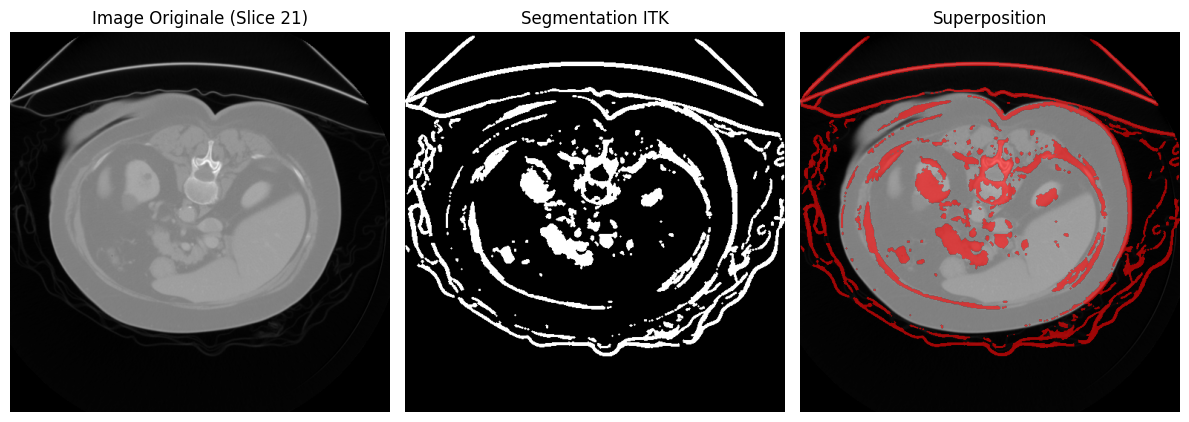



Visualisation pour hepaticvessel_011.nii.gz
Affichage de la coupe Z = 16


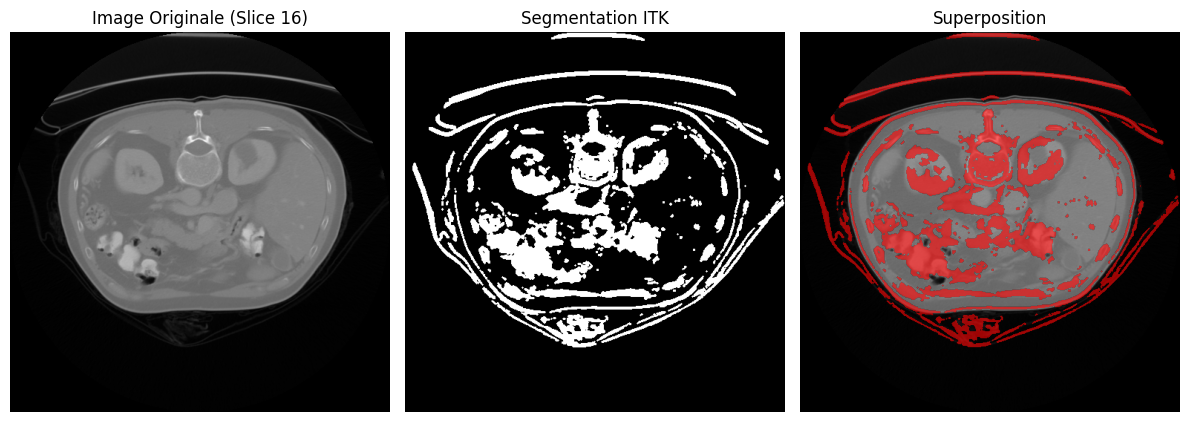



Visualisation pour hepaticvessel_013.nii.gz
Affichage de la coupe Z = 22


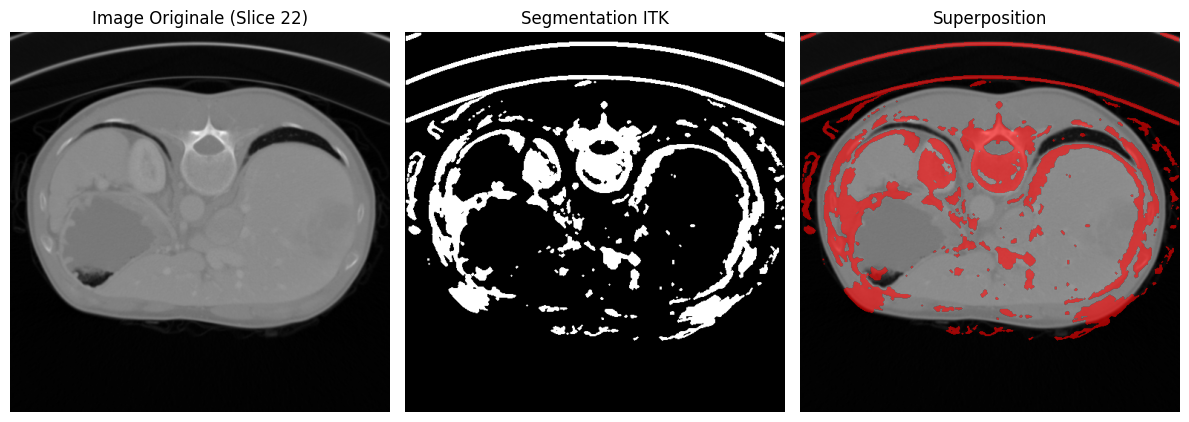



Visualisation pour hepaticvessel_016.nii.gz
Affichage de la coupe Z = 7


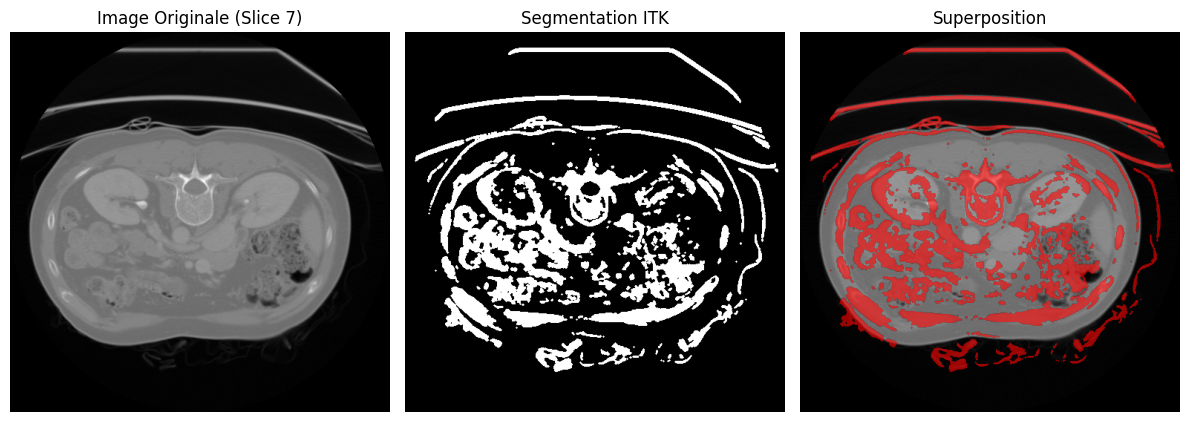



Visualisation pour hepaticvessel_018.nii.gz
Affichage de la coupe Z = 15


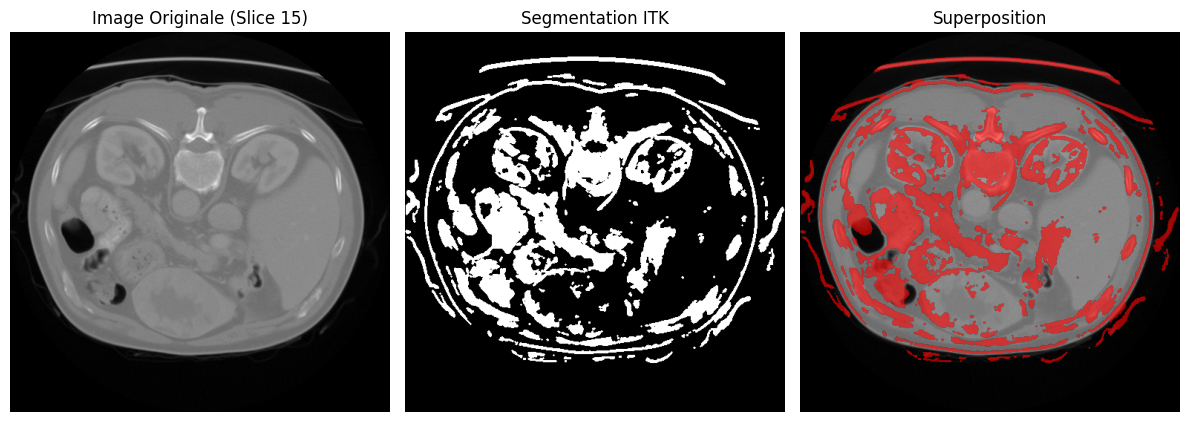



Visualisation pour hepaticvessel_019.nii.gz
Affichage de la coupe Z = 21


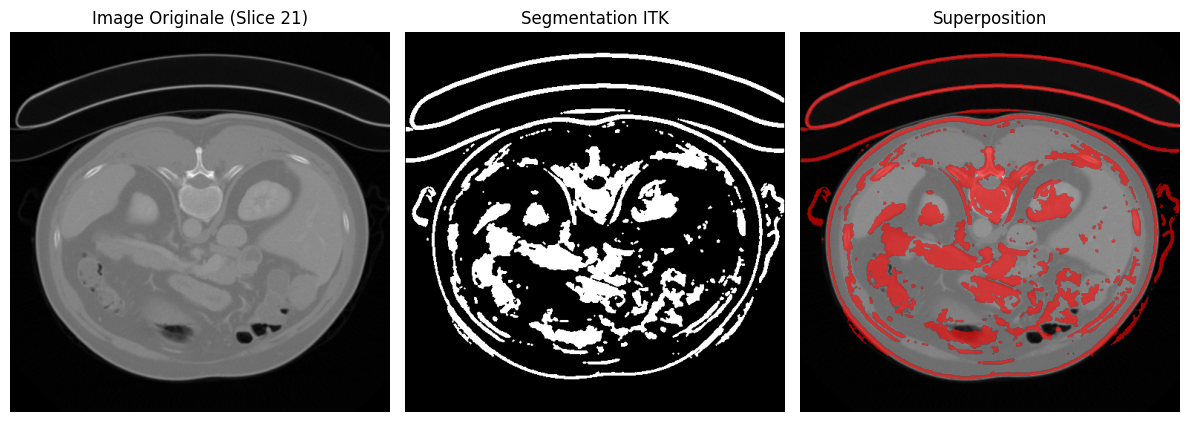



Visualisation pour hepaticvessel_020.nii.gz
Affichage de la coupe Z = 21


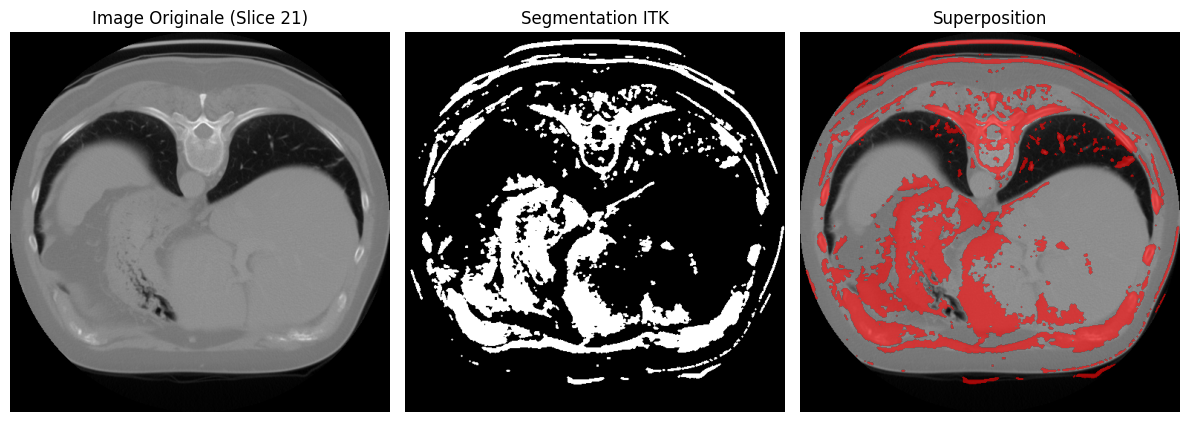



Visualisation pour hepaticvessel_022.nii.gz
Affichage de la coupe Z = 17


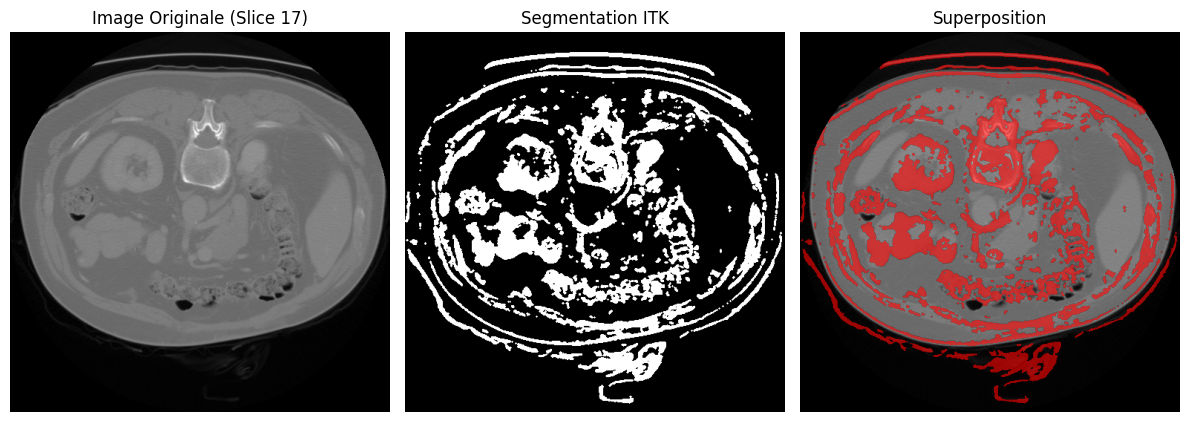



Visualisation pour hepaticvessel_023.nii.gz
Affichage de la coupe Z = 5


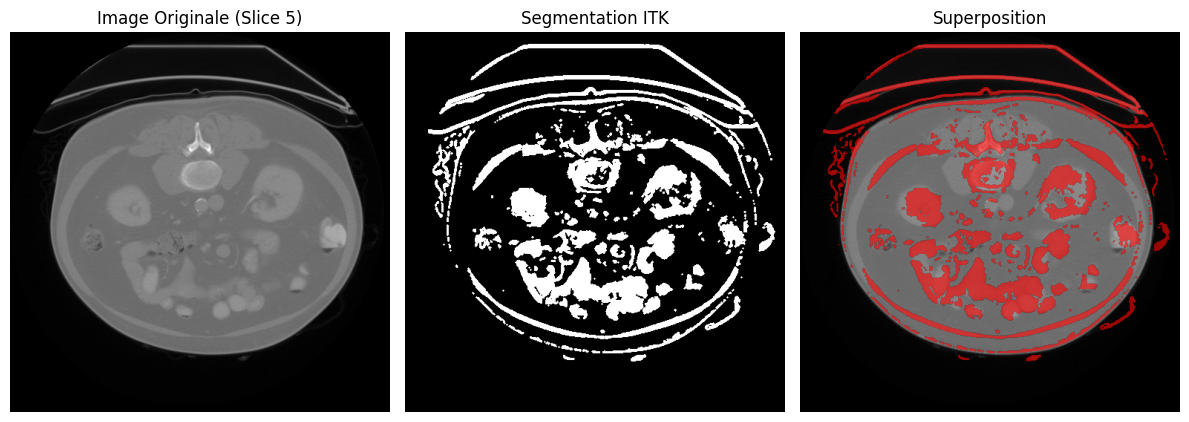



Visualisation pour hepaticvessel_025.nii.gz
Affichage de la coupe Z = 51


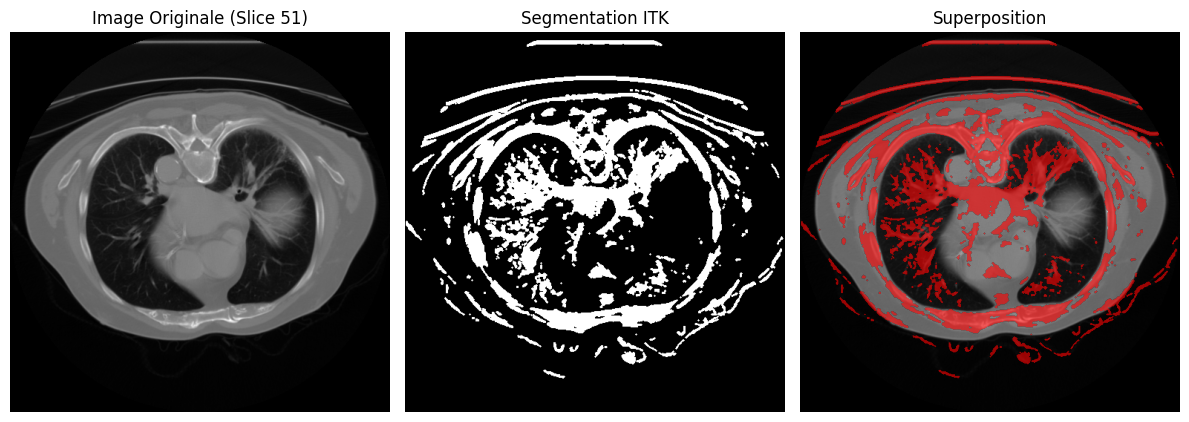



Visualisation pour hepaticvessel_026.nii.gz
Affichage de la coupe Z = 13


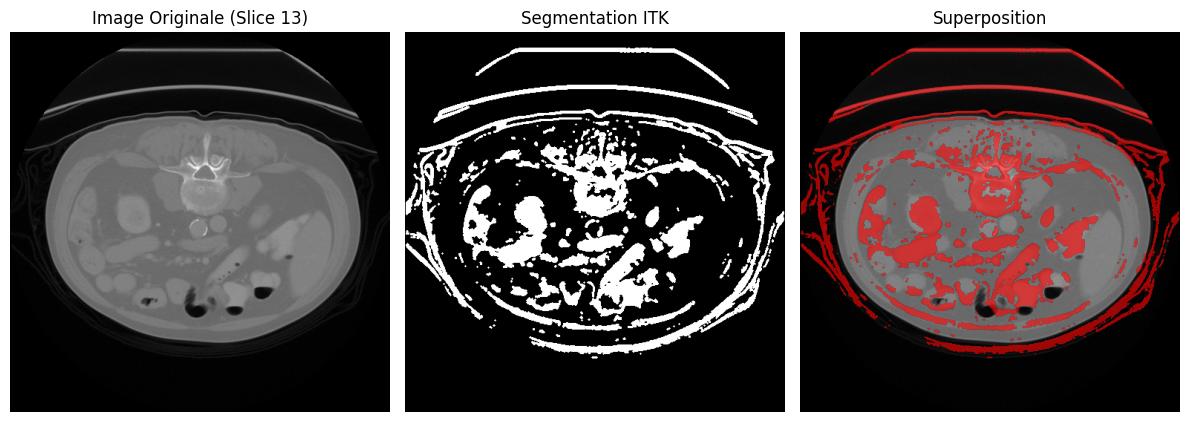



Visualisation pour hepaticvessel_027.nii.gz
Affichage de la coupe Z = 34


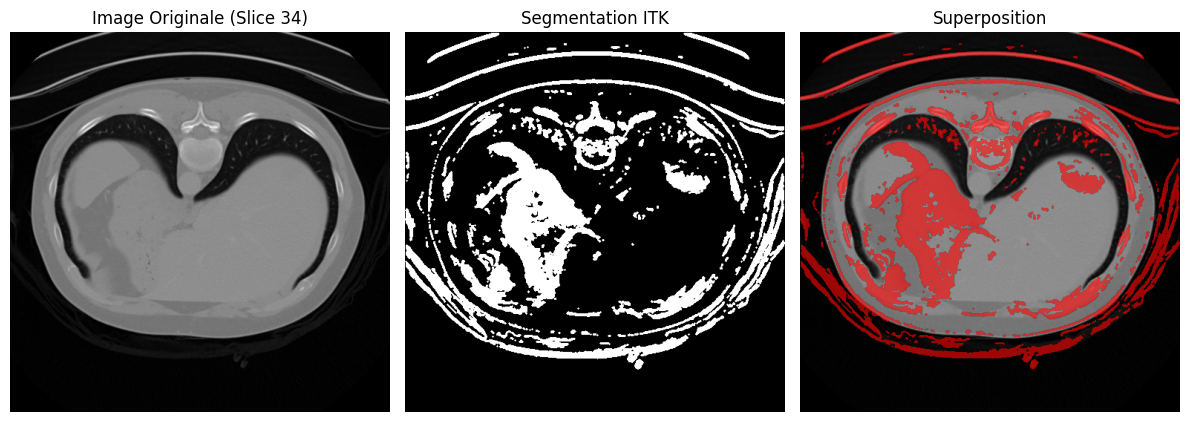



Visualisation pour hepaticvessel_028.nii.gz
Affichage de la coupe Z = 5


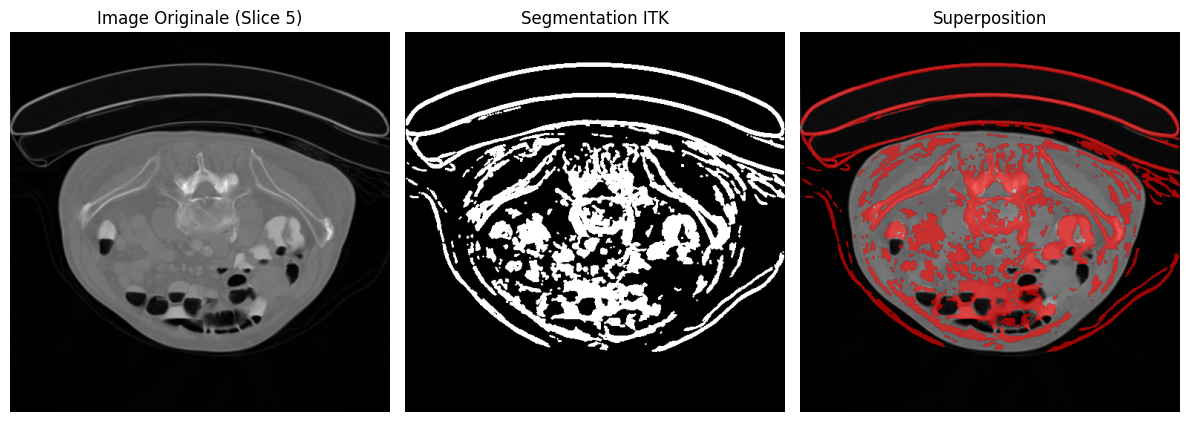



Visualisation pour hepaticvessel_029.nii.gz
Affichage de la coupe Z = 11


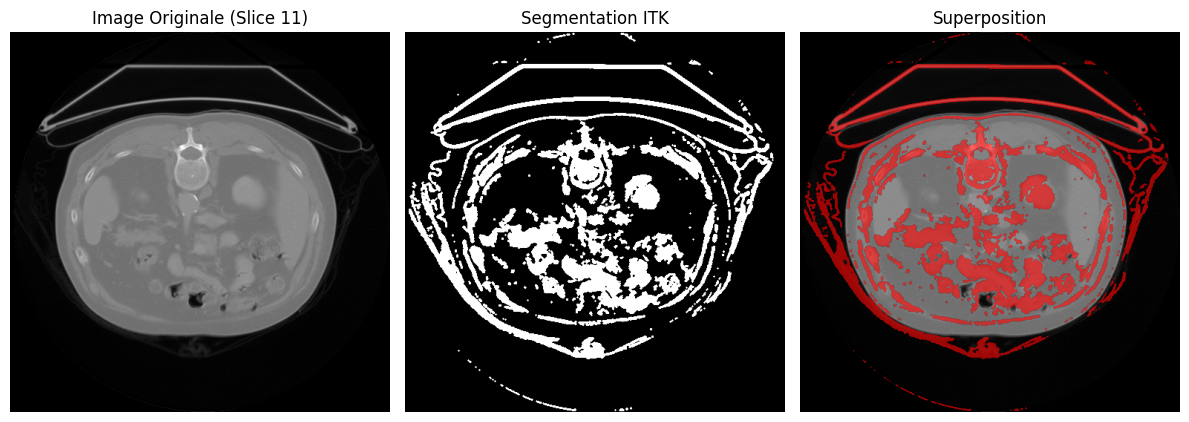

In [48]:
def visualize_results(image_path, mask_path, slice_idx=None):
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        print("Erreur : Fichiers introuvables.")
        return

    # Chargement des images avec ITK
    img_itk = itk.imread(image_path)
    mask_itk = itk.imread(mask_path)

    # Conversion en tableaux Numpy pour l'affichage
    img_np = itk.GetArrayFromImage(img_itk)
    mask_np = itk.GetArrayFromImage(mask_itk)

    # Choix de la coupe
    if slice_idx is None:
        # Somme des pixels par slice pour trouver celle avec le plus de vaisseaux
        vessel_counts = np.sum(mask_np, axis=(1, 2))
        slice_idx = np.argmax(vessel_counts)
        
        if vessel_counts[slice_idx] == 0:
            print("Aucun vaisseau détecté dans le masque. Affichage de la coupe centrale.")
            slice_idx = img_np.shape[0] // 2
    
    print(f"Affichage de la coupe Z = {slice_idx}")

    # Affichage avec Matplotlib
    plt.figure(figsize=(12, 6))

    # Image Originale
    plt.subplot(1, 3, 1)
    plt.title(f"Image Originale (Slice {slice_idx})")
    plt.imshow(img_np[slice_idx, :, :], cmap='gray')
    plt.axis('off')

    # Segmentation 
    plt.subplot(1, 3, 2)
    plt.title("Segmentation ITK")
    plt.imshow(mask_np[slice_idx, :, :], cmap='gray')
    plt.axis('off')

    # Superposition 
    plt.subplot(1, 3, 3)
    plt.title("Superposition")
    plt.imshow(img_np[slice_idx, :, :], cmap='gray')
    masked_data = np.ma.masked_where(mask_np[slice_idx, :, :] == 0, mask_np[slice_idx, :, :])
    plt.imshow(masked_data, cmap='autumn', alpha=0.6)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_files = sorted(glob(os.path.join(IMAGES_TR_DIR, "*.nii.gz")))

k = 20
for img_path in image_files[:k]:
    base_name = os.path.basename(img_path).replace("hepaticvessel_", "prediction_itk_")
    mask_path = os.path.join(DATA_ROOT, "predictions_itk", base_name)
    print(f"Visualisation pour {os.path.basename(img_path)}")
    visualize_results(img_path, mask_path)
    print("\n")

L'évaluation du pipeline ITK illustrent parfaitement les limites de cette méthode traditionnelle face à un problème complexe.

Sur le plan de l'extraction de caractéristiques, l'approche est fonctionnelle : l'opération morphologique de White Top-Hat a démontré une bonne sensibilité pour isoler les structures locales à fort contraste. Le filtre a correctement réagi aux gradients d'intensité élevés présents autour des vaisseaux.

Cependant,le résultat souffre d'un taux élevé de Faux Positifs. L'algorithme, se basant uniquement sur l'intensité radiométrique et la morphologie locale, échoue à discriminer les classes sémantiques. Il existe un chevauchement entre les distributions d'intensité des structures osseuses, des vaisseaux et des tumeurs.

En conséquence, le pipeline se comporte comme un classifieur binaire naïf et s'avère incapable d'effectuer une segmentation multi-classe. Il agglomère les vaisseaux (label 1), les tumeurs (label 2) et les artefacts osseux dans une même région d'intérêt, sans distinction. Cette incapacité à capturer le contexte sémantique confirme que des features sélectionnés manuellement sont insuffisantes pour ce problème et justifie la transition vers une approche de Deep Learning.

# MONAI

Utilisation du device : cpu
Total fichiers disponibles : 303
!!! MODE DEBUG ACTIVÉ : Utilisation de 55 fichiers seulement !!!
Train size: 50 | Val size: 5
Création des Datasets (Lecture disque directe)...
Test du premier item...
ERREUR lors de la transformation : list indices must be integers or slices, not str
Démarrage de l'entraînement...
Ep: 1, Step: 10, Loss: 1.9643
Ep: 1, Step: 20, Loss: 1.7986
Ep: 1, Step: 30, Loss: 1.8241
Ep: 1, Step: 40, Loss: 1.7620
Ep: 1, Step: 50, Loss: 1.7442
Epoch 1/150 - Avg Loss: 1.8285
Ep: 2, Step: 10, Loss: 1.6696
Ep: 2, Step: 20, Loss: 1.5852
Ep: 2, Step: 30, Loss: 1.6434
Ep: 2, Step: 40, Loss: 1.6102
Ep: 2, Step: 50, Loss: 1.5416
Epoch 2/150 - Avg Loss: 1.6326
Ep: 3, Step: 10, Loss: 1.5531
Ep: 3, Step: 20, Loss: 1.5726
Ep: 3, Step: 30, Loss: 1.4972
Ep: 3, Step: 40, Loss: 1.4369
Ep: 3, Step: 50, Loss: 1.4812
Epoch 3/150 - Avg Loss: 1.5313
Ep: 4, Step: 10, Loss: 1.4812
Ep: 4, Step: 20, Loss: 1.4384
Ep: 4, Step: 30, Loss: 1.4256
Ep: 4, Step: 40, Loss: 

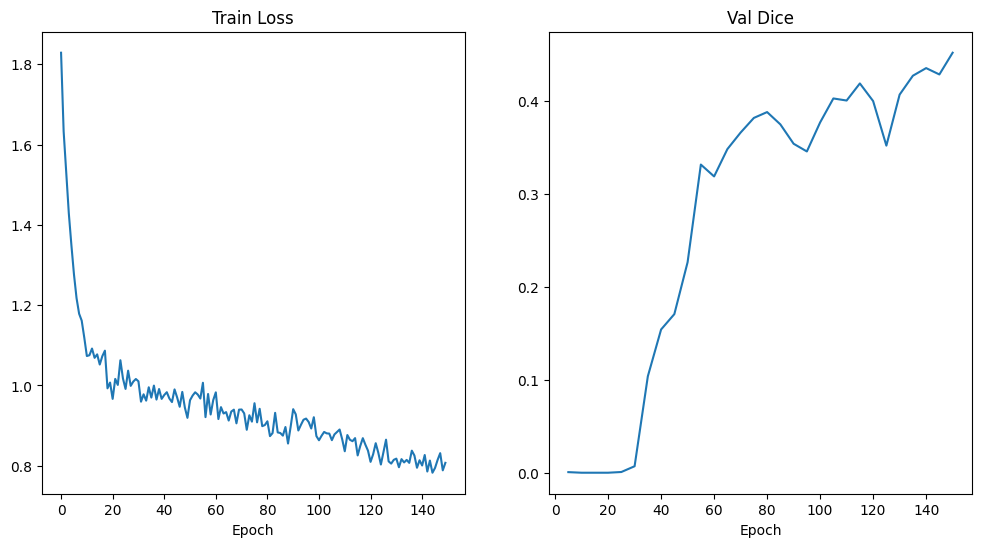

: 

In [ ]:
import os
import json
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandShiftIntensityd,
    EnsureTyped,
    SpatialPadd,
)
from monai.data import CacheDataset, DataLoader, decollate_batch, partition_dataset
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
set_determinism(seed=0)
DATA_DIR = "Task08_HepaticVessel/Task08_HepaticVessel" 
JSON_PATH = os.path.join(DATA_DIR, "dataset.json")
MAX_EPOCHS = 150
VAL_INTERVAL = 5
BATCH_SIZE = 1
LR = 1e-4

ROI_SIZE = (64, 64, 32) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

# ---------------------------------------------------------
# 2. PRÉPARATION DES DONNÉES (MODE DEBUG)
# ---------------------------------------------------------
with open(JSON_PATH, 'r') as f:
    data_dict = json.load(f)

all_files = []
for item in data_dict['training']:
    img_path = os.path.join(DATA_DIR, item['image'])
    lbl_path = os.path.join(DATA_DIR, item['label'])
    all_files.append({"image": img_path, "label": lbl_path})


print(f"Total fichiers disponibles : {len(all_files)}")
print("!!! MODE DEBUG ACTIVÉ : Utilisation de 55 fichiers seulement !!!")

train_ds_files = all_files[:50] 
val_ds_files = all_files[50:55]

print(f"Train size: {len(train_ds_files)} | Val size: {len(val_ds_files)}")

# ---------------------------------------------------------
# 3. TRANSFORMATIONS ROBUSTES
# ---------------------------------------------------------
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    
    # Normalisation Spatiale
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    
    # Normalisation Intensité
    ScaleIntensityRanged(
        keys=["image"], a_min=-50.0, a_max=350.0, b_min=0.0, b_max=1.0, clip=True,
    ),
    
    # Crop Foreground
    CropForegroundd(keys=["image", "label"], source_key="image"),
    
    # SÉCURITÉ : Padding si l'image est plus petite que le ROI_SIZE
    SpatialPadd(keys=["image", "label"], spatial_size=ROI_SIZE),

    # Sampling
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=ROI_SIZE,
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 1]),
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    EnsureTyped(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"], a_min=-50.0, a_max=350.0, b_min=0.0, b_max=1.0, clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

# ---------------------------------------------------------
# 4. DATASETS ET LOADERS 
# ---------------------------------------------------------
from monai.data import Dataset 

print("Création des Datasets (Lecture disque directe)...")

train_ds = Dataset(data=train_ds_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

val_ds = Dataset(data=val_ds_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

# Petit test immédiat pour vérifier que la première image passe les transfos
print("Test du premier item...")
try:
    first_item = train_ds[0]
    print(f"Succès ! Shape image transformée : {first_item['image'].shape}")
except Exception as e:
    print(f"ERREUR lors de la transformation : {e}")
    exit()
    
# ---------------------------------------------------------
# 5. MODÈLE & TRAINING LOOP
# ---------------------------------------------------------
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3, 
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="batch",
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dice_metric = DiceMetric(include_background=False, reduction="mean")

print("Démarrage de l'entraînement...")

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_metric_values = []

for epoch in range(MAX_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # Petit print pour voir que ça avance
        if step % 10 == 0:
            print(f"Ep: {epoch+1}, Step: {step}, Loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{MAX_EPOCHS} - Avg Loss: {epoch_loss:.4f}")

    # Validation
    if (epoch + 1) % VAL_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                
                # Sliding Window Inference
                val_outputs = sliding_window_inference(
                    inputs=val_inputs, 
                    roi_size=ROI_SIZE, 
                    sw_batch_size=1,  
                    predictor=model,
                    overlap=0.25      
                )
                
                # Metric calculation
                val_outputs_list = decollate_batch(val_outputs)
                val_labels_list = decollate_batch(val_labels)
                
                val_outputs_discrete = [torch.argmax(i, dim=0, keepdim=True) for i in val_outputs_list]
                
                dice_metric(y_pred=val_outputs_discrete, y=val_labels_list)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            val_metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pt")
                print(f" > Sauvegarde Modèle (Dice: {best_metric:.4f})")
            
            print(f"Validation Epoch {epoch + 1} - Dice: {metric:.4f}")

print(f"Fin. Best Dice: {best_metric:.4f} @ Epoch {best_metric_epoch}")

# Plot
plt.figure("Train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(epoch_loss_values)
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.title("Val Dice")
x_val = [VAL_INTERVAL * (i + 1) for i in range(len(val_metric_values))]
plt.plot(x_val, val_metric_values)
plt.xlabel("Epoch")
plt.savefig("learning_curves.png")
plt.show()

/home/clement/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-12-28 07:23:07.159914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766902987.178367   89668 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766902987.183831   89668 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-28 07:23:07.202672: I tensorflow/core/platform/cpu_fe

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user vi

✅ Modèle chargé.
Image chargée : torch.Size([1, 1, 408, 364, 124])


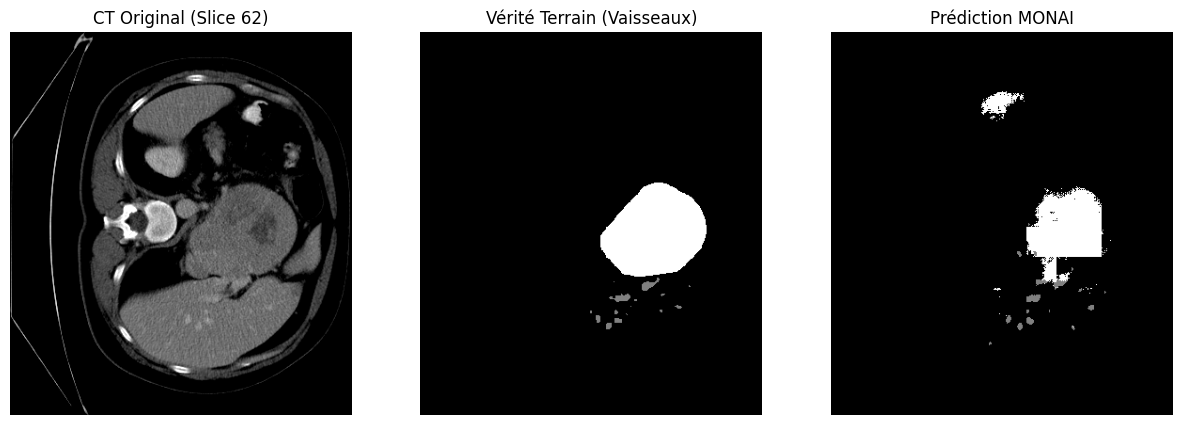

In [1]:
import torch
import matplotlib.pyplot as plt
import os
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, 
    Orientationd, ScaleIntensityRanged, CropForegroundd, EnsureTyped
)
from monai.data import Dataset, DataLoader

# --- 1. CONFIGURATION ---
DATA_DIR = "Task08_HepaticVessel/Task08_HepaticVessel/"  # Vérifiez que c'est le bon dossier
device = torch.device("cpu")
ROI_SIZE = (64, 64, 32) # Doit correspondre à l'entraînement
MODEL_PATH = "best_metric_model.pt"

# --- 2. RECONSTRUCTION DU DATASET DE VALIDATION ---
# On refait juste le nécessaire pour charger une image proprement
import json
with open(os.path.join(DATA_DIR, "dataset.json"), 'r') as f:
    data_dict = json.load(f)

# On prend la 5ème image (celle utilisée pour la validation en mode debug)
val_files = [{"image": os.path.join(DATA_DIR, data_dict['training'][4]['image']),
              "label": os.path.join(DATA_DIR, data_dict['training'][4]['label'])}]

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-50.0, a_max=350.0, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

# --- 3. CHARGEMENT DU MODÈLE ---
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3, 
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="batch",
).to(device)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("✅ Modèle chargé.")
else:
    print(f"❌ Erreur : {MODEL_PATH} introuvable.")
    exit()

# --- 4. INFÉRENCE & VISUALISATION ---
model.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs = batch["image"].to(device)
        labels = batch["label"].to(device)
        
        print(f"Image chargée : {inputs.shape}")
        
        # Inférence par fenêtre glissante
        outputs = sliding_window_inference(inputs, ROI_SIZE, 1, model, overlap=0.25)
        # Argmax pour avoir la classe (0, 1 ou 2)
        preds = torch.argmax(outputs, dim=1)
        
        # Sélection de la coupe centrale pour l'affichage
        slice_idx = inputs.shape[4] // 2
        
        plt.figure(figsize=(15, 5))
        
        # Image CT
        plt.subplot(1, 3, 1)
        plt.title(f"CT Original (Slice {slice_idx})")
        plt.imshow(inputs[0, 0, :, :, slice_idx].cpu(), cmap="gray")
        plt.axis('off')
        
        # Vrai Label
        plt.subplot(1, 3, 2)
        plt.title("Vérité Terrain (Vaisseaux)")
        plt.imshow(labels[0, 0, :, :, slice_idx].cpu(), cmap="gray")
        plt.axis('off')
        
        # Prédiction IA
        plt.subplot(1, 3, 3)
        plt.title("Prédiction MONAI")
        plt.imshow(preds[0, :, :, slice_idx].cpu(), cmap="gray")
        plt.axis('off')
        
        plt.show()
        break # On ne fait qu'une image

L'évaluation du pipeline basé sur un modèle UNet révèle des performances nettement supérieures, bien que contraintes par les ressources de calcul.

L'analyse des courbes d'apprentissage illustre une dynamique d'optimisation non-linéaire intéressante. Durant la phase initiale (époques 0-30), le modèle a traversé un plateau de performance, suggérant une difficulté initiale à trouver la direction du gradient optimal dans un espace de recherche complexe et déséquilibré. La rupture de pente observée à l'époque 30 marque le franchissement d'un point d'inflexion (ou la sortie d'un minimum local), déclenchant une convergence rapide de la loss et une augmentation rapide du Dice Score.

Sur le plan de l'inférence, le modèle démontre une excellente capacité de généralisation et de compréhension contextuelle. Contrairement à l'approche heuristique, le réseau a appris des représentations hiérarchiques lui permettant de filtrer efficacement les faux positifs. Il discrimine parfaitement les structures anatomiques non pertinentes (os, autres organes, etc), prouvant qu'il a acquis une compréhension sémantique de la tâche de segmentation multi-classe.

Cependant, les prédictions actuelles présentent encore des signes de sous-segmentation et d'approximations. Cette limitation est directement imputable à une convergence inachevée du modèle. Les contraintes matérielles nous ont contraints à restreindre la taille du dataset d'entraînement (50 volumes) et le nombre d'époques, limitant ainsi la capacité de généralisation du réseau.

Le passage à l'échelle sur une infrastructure GPU permettrait d'exploiter l'intégralité du jeu de données et de prolonger la phase d'optimisation jusqu'à la convergence totale de la loss function. En l'état, ces résultats valident solidement la Proof of Concept et confirment la viabilité de l'architecture.